<a href="https://colab.research.google.com/github/yurigalindo/DaemonPS/blob/main/Problem_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Problem 3: Web Scraping and Estimation



In [1]:
import warnings
warnings.filterwarnings("ignore") #This ignores all warnings, useful for generating a readable notebook.
#Warnings should not be ignored when developing since they may contain useful info.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## 1. 2. 3. Web Scraper, partial answer

In [2]:
from bs4 import BeautifulSoup

import requests
headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.102 Safari/537.36'}
#headers are needed or the access would be denied
html = requests.get("https://www.investing.com/equities/barrick-gold-corp.-historical-data",headers=headers).content
#storing a get request
soup = BeautifulSoup(html, 'html.parser') #parsing the request with beautifulsoup

In [3]:
prices = soup.find_all('td', class_=["redFont", "greenFont"],attrs={"data-real-value": True})
#These are the attributes of the html element that holds the price
for price in prices:
    print(price.text) #The text corresponds to the price we want

23.15
23.23
23.71
23.01
23.12
23.41
23.46
23.21
24.17
24.26
24.08
23.86
24.58
24.58
24.68
24.70
24.81
24.59
25.11
25.27


I wasn't able to build a crawler in time due to the interaction with javascript objects needed to display the desired data. I was able to build a scraper that got the prices of a given investing.com webpage.

I downloaded the historical data manually using the "Download Data" feature of the website, going back 12 months. The following estimation will be done with the downloaded csvs.

TODO: web scraper

## 4. Estimation

In [4]:
copper = pd.read_csv('Copper Futures Historical Data.csv')
barrick = pd.read_csv('GOLD Historical Data.csv')
gold = pd.read_csv('Gold Futures Historical Data.csv', thousands=',')

In [5]:
copper.drop(['Open','High','Low','Vol.','Change %'],axis=1,inplace=True) #Dropping unnecessary columns
barrick.drop(['Open','High','Low','Vol.','Change %'],axis=1,inplace=True)
gold.drop(['Open','High','Low','Vol.','Change %'],axis=1,inplace=True)

In [6]:
df=copper.set_index('Date').join(gold.set_index('Date'),lsuffix='_copper', how = 'inner', rsuffix='_gold')
#Joining the copper and gold datasets using the date as index

In [7]:
df=df.join(barrick.set_index('Date'),how='inner',rsuffix='_barrick') #Inner join to remove missing dates

In [8]:
X,y = np.array(df.iloc[:,:-1]), np.array(df.iloc[:,-1]) #Separating the columns into np arrays for the regression

from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
regressor.fit(X, y) #Fit the model

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [ ]:
regressor.coef_ #Coefficients, left is copper and right is gold

array([-1.90447994,  0.02398571])

In [ ]:
regressor.intercept_ #Intercept

-13.283783090223842

Analyzing the coefficients doesn't tell us if the copper or gold price is more important since they have different magnitudes.

But it indicates the sign of the relationship, that an increase in gold prices lead to an increase in GOLD US Equity and that a decrease in copper prices lead to an increase in GOLD US Equity.

Now let's analyze the residuals to see if the linear model is a good fit.

In [9]:
import seaborn as sns
import scipy.stats as stats

Text(0.5, 1.0, 'Residual plot')

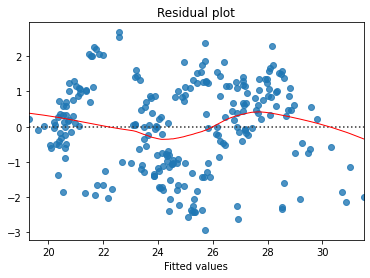

In [10]:
predictions = regressor.predict(X)
sns.residplot(x=predictions.reshape(-1), y=y,lowess=True,line_kws={'color': 'red', 'lw': 1, 'alpha': 1})
plt.xlabel("Fitted values")
plt.title('Residual plot')

The Residual Plot seems okay, there are some tendencies that could be a sign of non-linearity but they are small

Text(0.5, 1.0, 'Normal Q-Q Plot')

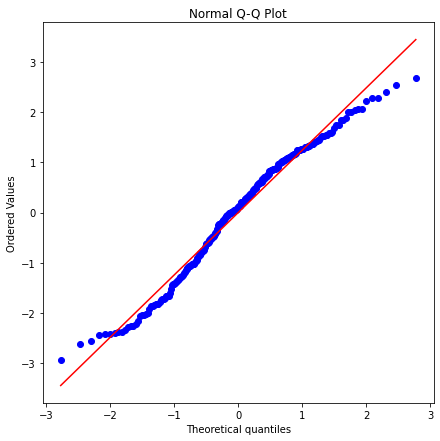

In [11]:
residuals = y - predictions.reshape(-1)
plt.figure(figsize=(7,7))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title("Normal Q-Q Plot")

The residuals seem to adhere well to a normal distribution, which is one of the assumptions made when interpreting a linear regression

Text(0.5, 0, 'Fitted value')

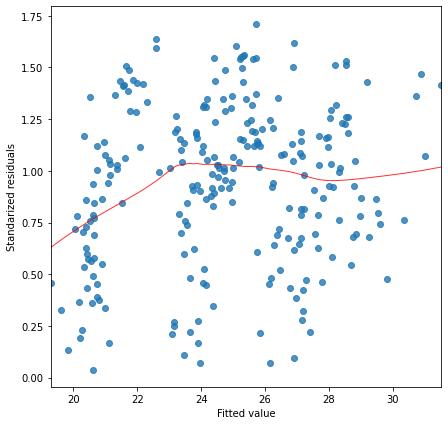

In [12]:
model_norm_residuals_abs_sqrt=np.sqrt(np.abs(residuals))

plt.figure(figsize=(7,7))
sns.regplot(predictions.reshape(-1), model_norm_residuals_abs_sqrt,
              scatter=True,
              lowess=True,
              line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})
plt.ylabel("Standarized residuals")
plt.xlabel("Fitted value")

The residuals show some signs of heteroscedasticity (unequal variance) for the first values, but they are minor. We can continue assuming equal variance of the residuals and compute the p-values of the coefficients.

This time we'll standardize the gold and copper prices in order to know the relative importance of each one.

In [13]:
from sklearn import preprocessing
X_standardized = preprocessing.StandardScaler().fit_transform(X)

In [15]:
import statsmodels.api as sm
X_standardized = sm.add_constant(X_standardized) #adding a constant term needed by this library
logit_model=sm.OLS(y,X_standardized)
result=logit_model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.836
Model:                            OLS   Adj. R-squared:                  0.835
Method:                 Least Squares   F-statistic:                     631.8
Date:                Tue, 15 Jun 2021   Prob (F-statistic):           4.62e-98
Time:                        01:12:49   Log-Likelihood:                -410.35
No. Observations:                 251   AIC:                             826.7
Df Residuals:                     248   BIC:                             837.3
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         24.7240      0.079    313.742      0.0

In [16]:
print(result.pvalues)

[0.00000000e+00 1.14493088e-27 1.41580343e-60]


The p-values are very low, and if we were testing the hypothesis of the 1st coefficient being negative and the second being positive, we would be able to reject the null hypothesis with all usual alphas.

By standardizing the prices, we can see that the price of gold is approximately twice as important as the copper price. The copper price has a negative influence on US Gold Equity, and the gold price has a positive influence.